In [705]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [706]:
country_to_predict="Venezuela"

**ARIMA**


In [707]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
392,1970-01-01,64.935,Venezuela
393,1971-01-01,65.428,Venezuela
394,1972-01-01,65.896,Venezuela
395,1973-01-01,66.331,Venezuela
396,1974-01-01,66.729,Venezuela


In [708]:
del df["Country"]

In [709]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [710]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

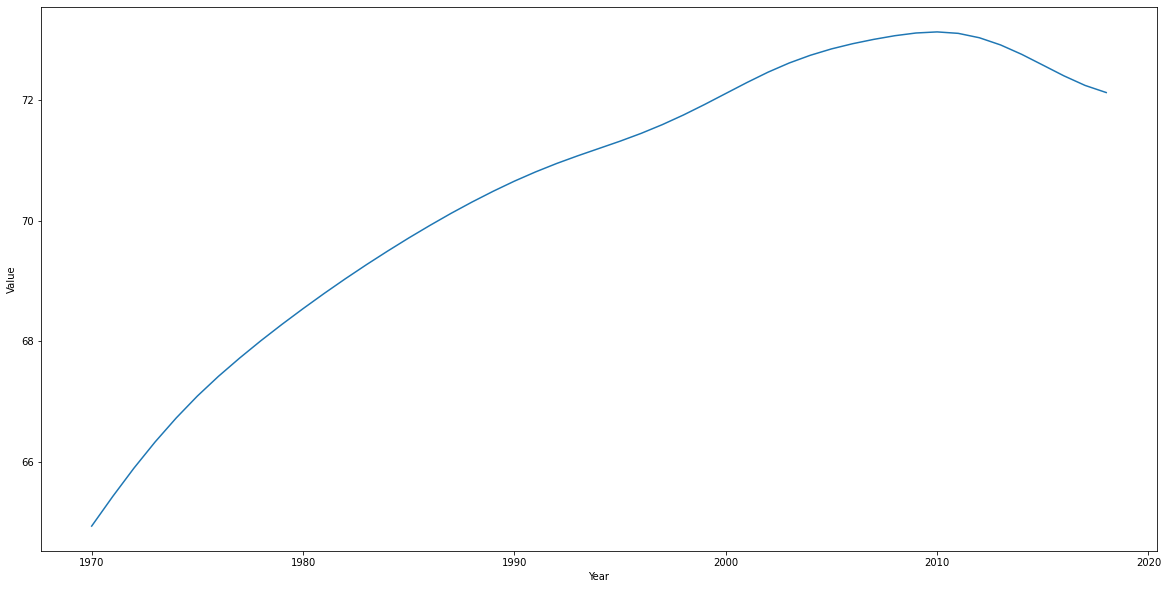

In [711]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [712]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  66.068500
1976-01-01  66.482667
1977-01-01  66.865167
1978-01-01  67.217333
1979-01-01  67.542333
1980-01-01  67.844500
1981-01-01  68.128333
1982-01-01  68.398000
1983-01-01  68.656167
1984-01-01  68.904167
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  0.809634
1976-01-01  0.747002
1977-01-01  0.683861
1978-01-01  0.626622
1979-01-01  0.578848
1980-01-01  0.541353
1981-01-01  0.513643
1982-01-01  0.491646
1983-01-01  0.472637
1984-01-01  0.455210


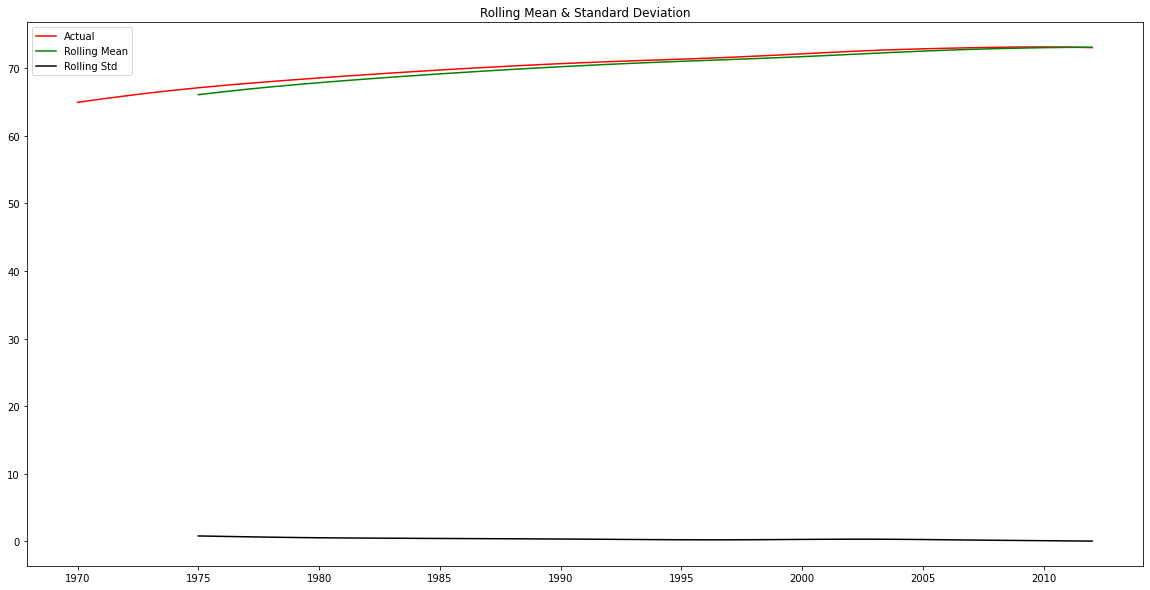

In [713]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [714]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -3.087914
p-value                  0.027461
Lags Used                7.000000
No. of Obs              35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64


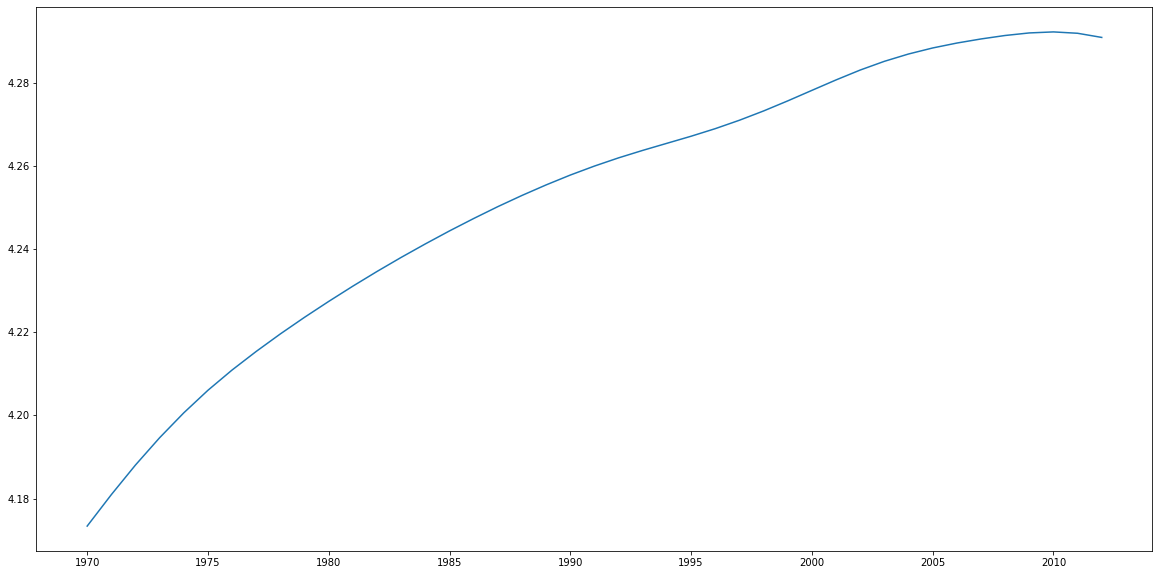

In [715]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

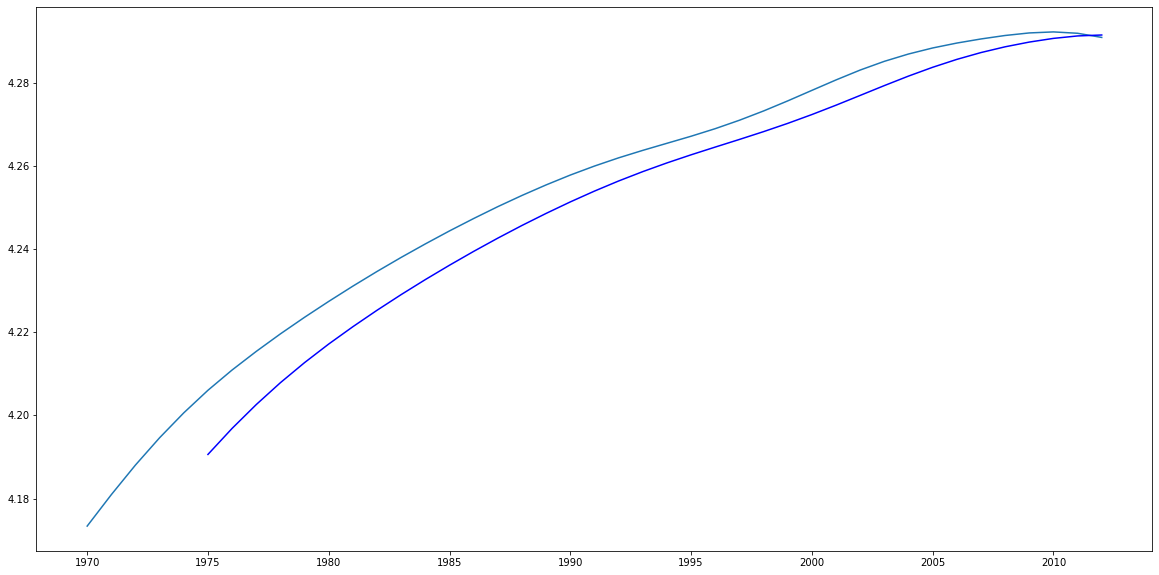

In [716]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [717]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.015435
1976-01-01,0.014053
1977-01-01,0.012791
1978-01-01,0.011745


In [718]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.015435
1976-01-01,0.014053
1977-01-01,0.012791
1978-01-01,0.011745
1979-01-01,0.010908


In [719]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

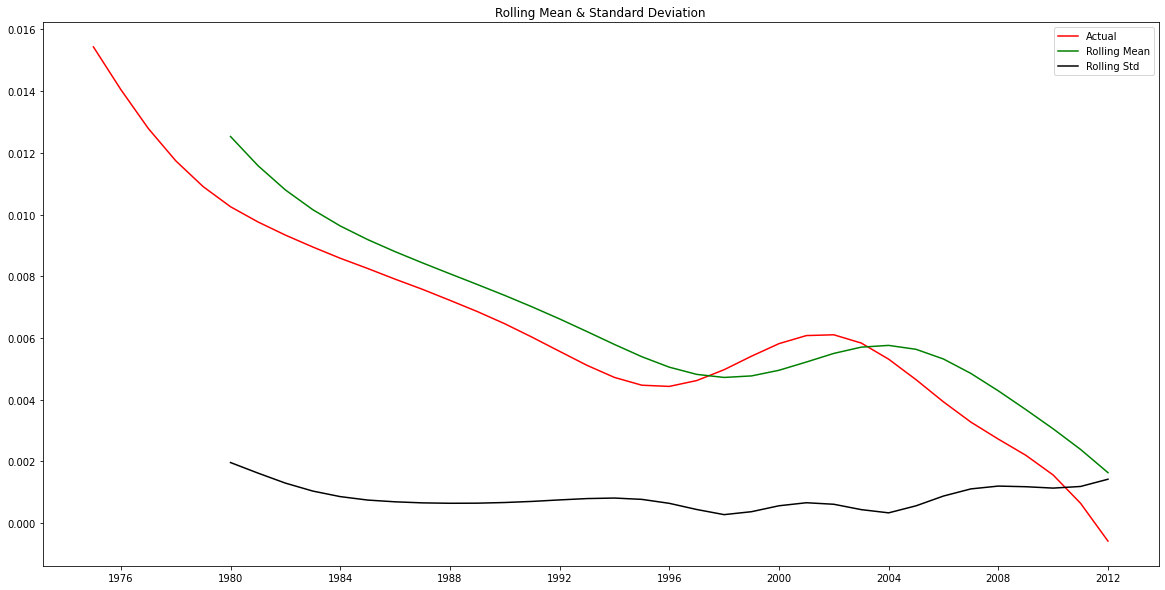

Dickey-Fuller Test: 
Test Statistic          -1.437114
p-value                  0.564360
Lags Used                6.000000
No. of Obs              31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
dtype: float64


In [720]:
stationarity(df_log_diff)

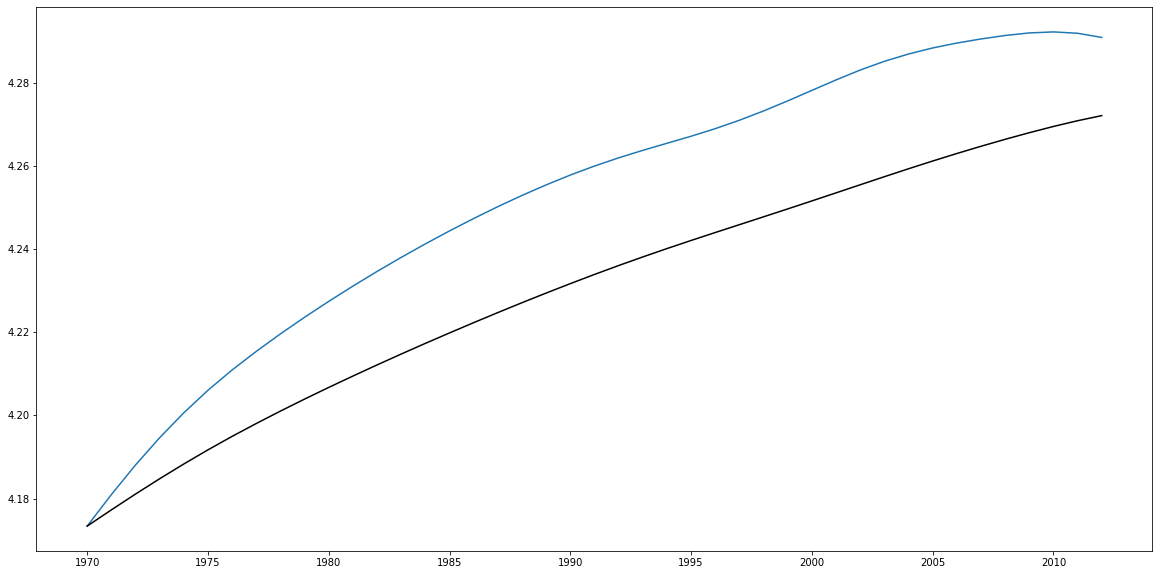

In [721]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

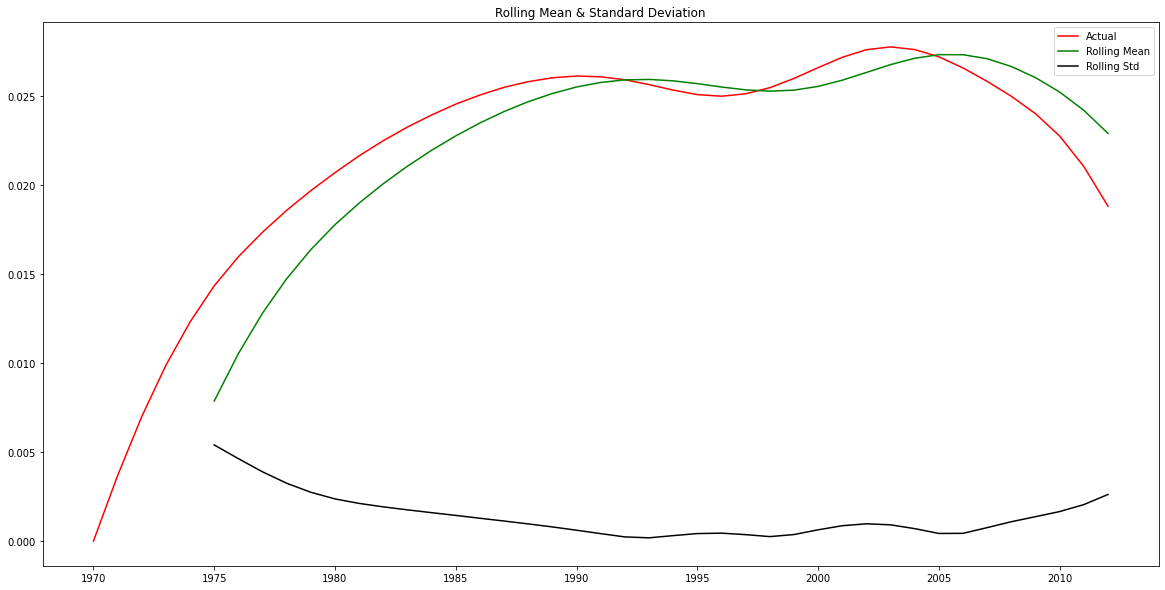

Dickey-Fuller Test: 
Test Statistic          -0.567021
p-value                  0.878261
Lags Used                7.000000
No. of Obs              35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64


In [722]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

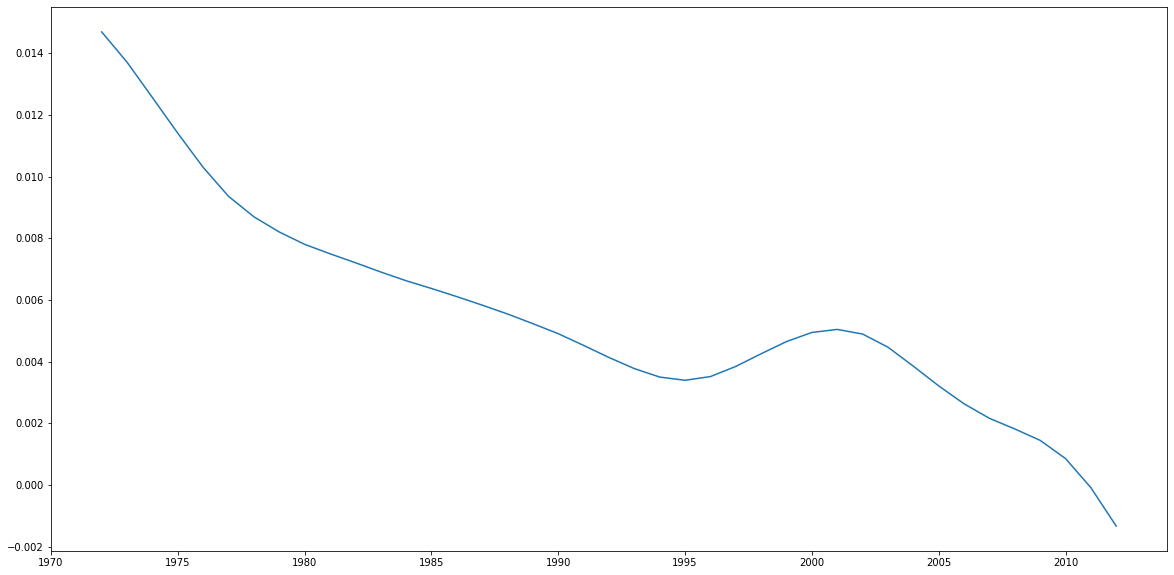

In [723]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

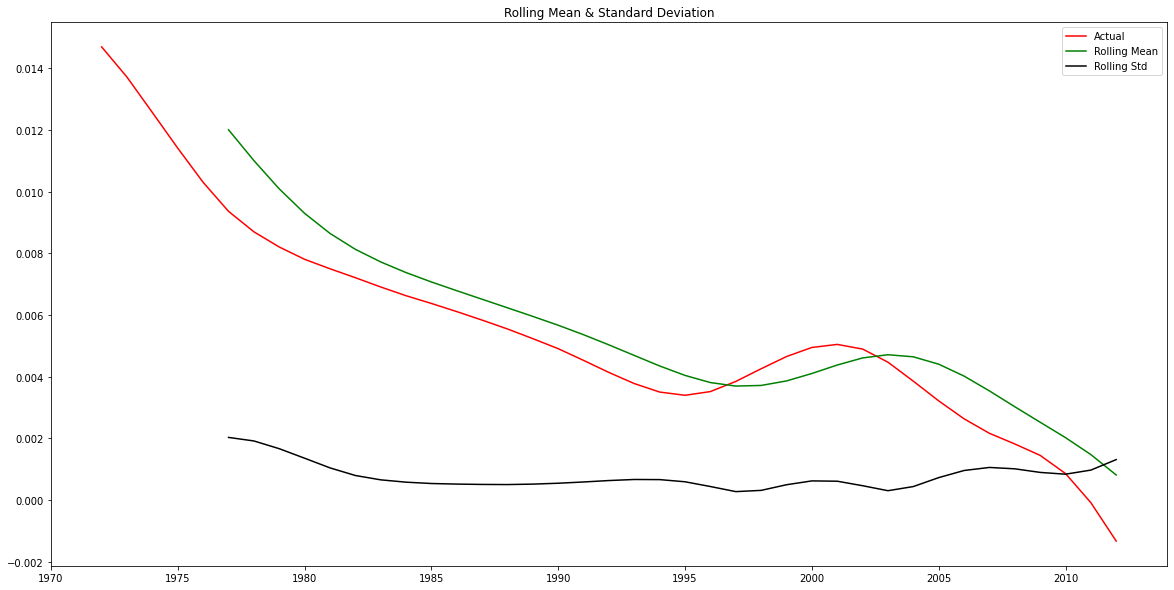

Dickey-Fuller Test: 
Test Statistic           0.769693
p-value                  0.991131
Lags Used                3.000000
No. of Obs              37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


In [724]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

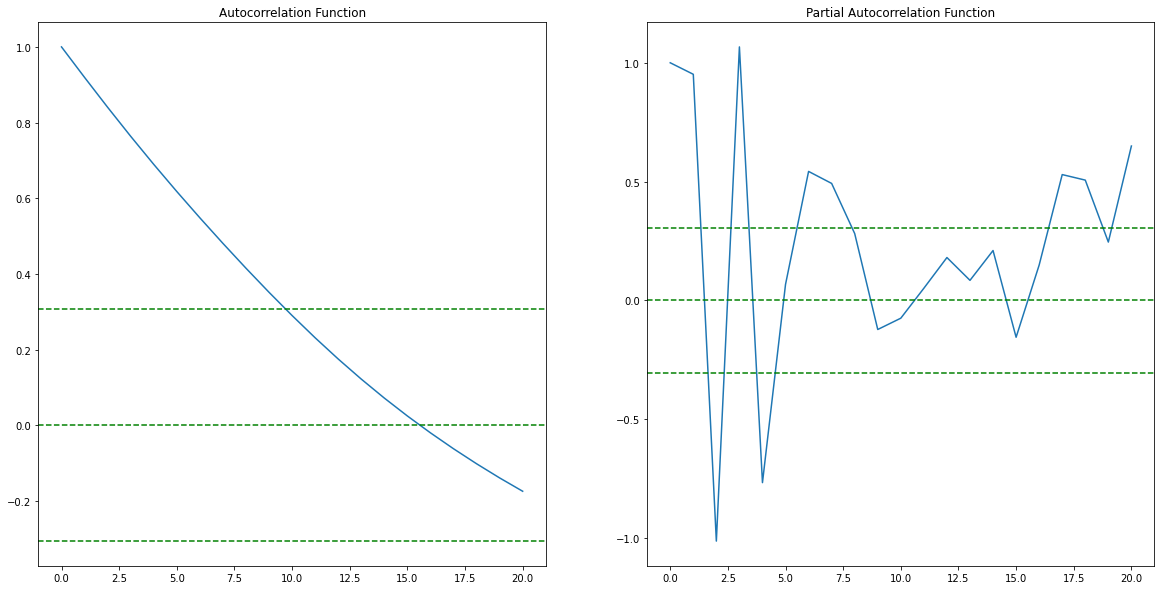

In [726]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(train_df, nlags=20)
lag_pacf=pacf(train_df, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


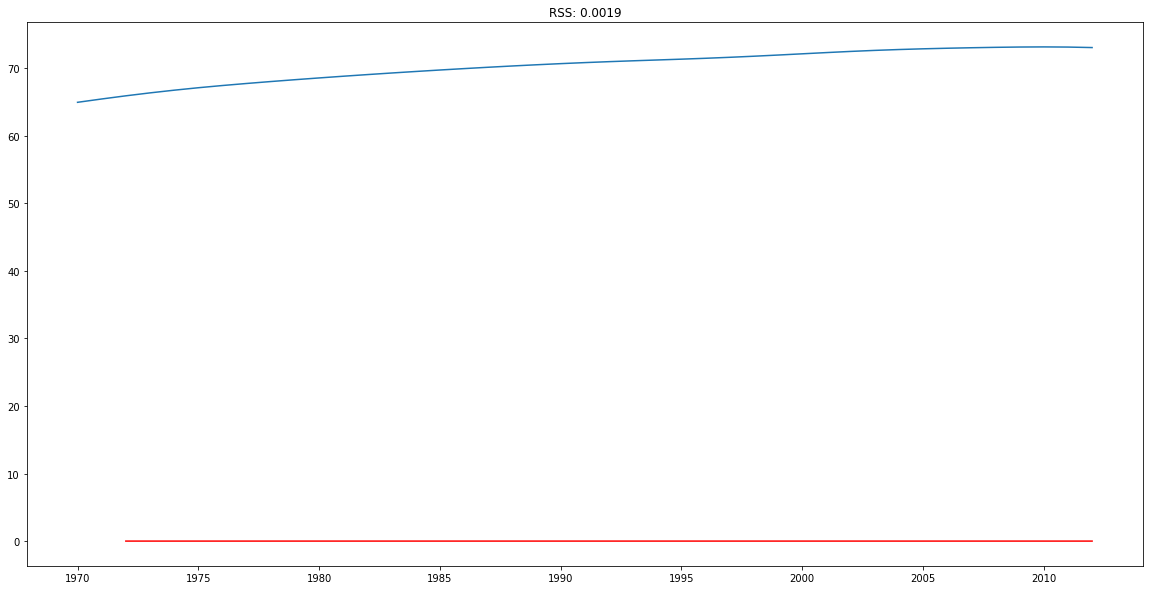

In [756]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(4,2,0))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [757]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1972-01-01   -0.000236
1973-01-01   -0.000421
1974-01-01   -0.000596
1975-01-01   -0.000587
1976-01-01   -0.000469
Freq: AS-JAN, dtype: float64


In [758]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1972-01-01   -0.000236
1973-01-01   -0.000658
1974-01-01   -0.001253
1975-01-01   -0.001840
1976-01-01   -0.002309
Freq: AS-JAN, dtype: float64


In [759]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [760]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


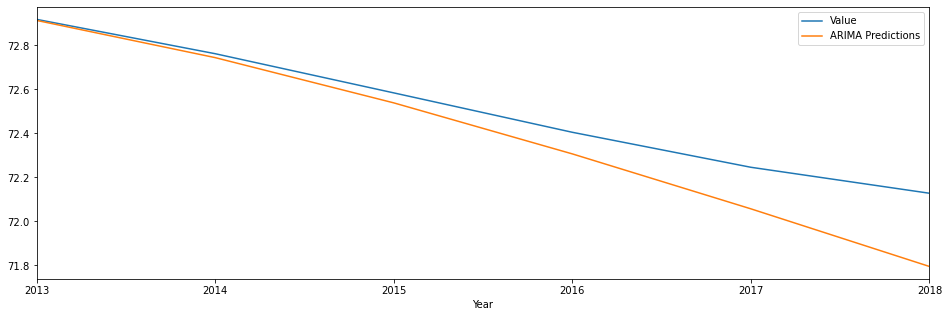

In [761]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [762]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.026382091549214014
RMSE Error: 0.16242564929595946
Mean: 70.56840816326532


In [763]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,71.523385,Venezuela
2020,71.240465,Venezuela
2021,70.944149,Venezuela
2022,70.631545,Venezuela
2023,70.300369,Venezuela
2024,69.949554,Venezuela
2025,69.579351,Venezuela


In [764]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [765]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,72.918,72.913225
2014-01-01,72.762,72.744175
2015-01-01,72.584,72.538649
2016-01-01,72.405,72.306843
2017-01-01,72.246,72.057233
2018-01-01,72.128,71.795393


**LSTM**

In [766]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [767]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,72.762
2015-01-01,72.584
2016-01-01,72.405
2017-01-01,72.246
2018-01-01,72.128


In [768]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [769]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 1
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [770]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [771]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
42/42 [==============================] - 0s 2ms/step - loss: 0.4587
Epoch 2/20
42/42 [==============================] - 0s 2ms/step - loss: 0.2994
Epoch 3/20
42/42 [==============================] - 0s 2ms/step - loss: 0.1641
Epoch 4/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 5/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 6/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 7/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 8/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 9/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 10/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 11/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 12/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/20
42/42 [==============================

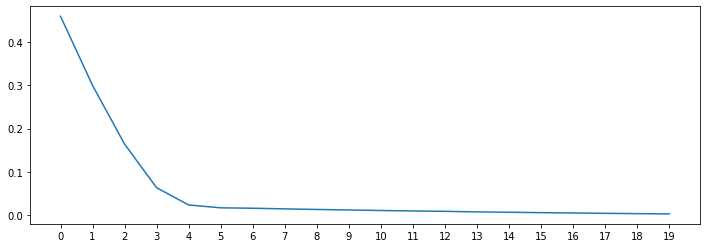

In [772]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [773]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [774]:
lstm_predictions_scaled

[array([0.96341556], dtype=float32),
 array([0.9410395], dtype=float32),
 array([0.92098564], dtype=float32),
 array([0.90315217], dtype=float32),
 array([0.88740414], dtype=float32),
 array([0.87358445], dtype=float32)]

In [775]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [776]:
lstm_predictions

array([[72.8340442 ],
       [72.65058288],
       [72.48616125],
       [72.33994462],
       [72.21082658],
       [72.0975189 ]])

In [777]:
test_df['LSTM_Predictions'] = lstm_predictions

In [778]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,72.918,72.913225,72.834044
2014-01-01,72.762,72.744175,72.650583
2015-01-01,72.584,72.538649,72.486161
2016-01-01,72.405,72.306843,72.339945
2017-01-01,72.246,72.057233,72.210827
2018-01-01,72.128,71.795393,72.097519


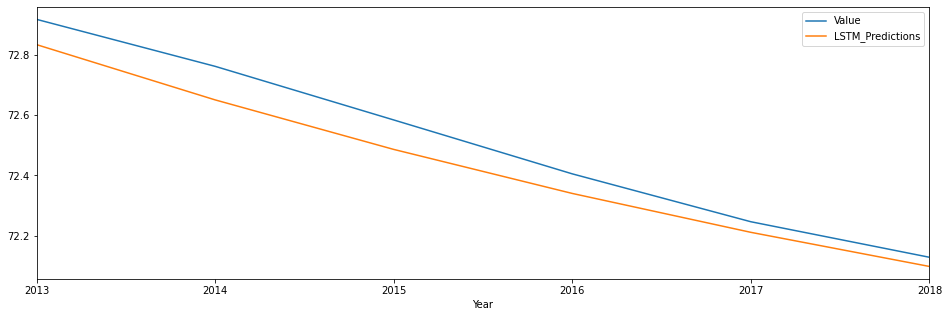

In [779]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [780]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.005905539920423127
RMSE Error: 0.07684751082776284
Mean: 70.56840816326532


In [781]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [782]:
lstm_predictions_scaled

[array([0.96341556], dtype=float32),
 array([0.9410395], dtype=float32),
 array([0.92098564], dtype=float32),
 array([0.90315217], dtype=float32),
 array([0.88740414], dtype=float32),
 array([0.87358445], dtype=float32),
 array([0.8615239], dtype=float32),
 array([0.8510499], dtype=float32),
 array([0.84199226], dtype=float32),
 array([0.83418864], dtype=float32),
 array([0.8274869], dtype=float32),
 array([0.8217473], dtype=float32)]

In [783]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [784]:
lstm_predictions

array([[72.8340442 ],
       [72.65058288],
       [72.48616125],
       [72.33994462],
       [72.21082658],
       [72.0975189 ],
       [71.99863467],
       [71.91275813],
       [71.83849453],
       [71.77451266],
       [71.71956487],
       [71.67250614]])

In [785]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,72.097519,Venezuela
2020,71.998635,Venezuela
2021,71.912758,Venezuela
2022,71.838495,Venezuela
2023,71.774513,Venezuela
2024,71.719565,Venezuela
2025,71.672506,Venezuela


In [786]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [787]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
436,2014,72.762
437,2015,72.584
438,2016,72.405
439,2017,72.246
440,2018,72.128


In [788]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
436,2014-01-01,72.762
437,2015-01-01,72.584
438,2016-01-01,72.405
439,2017-01-01,72.246
440,2018-01-01,72.128


In [789]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [790]:
from fbprophet import Prophet

In [791]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [792]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,12.209154,73.235413,73.377361,12.160943,12.258607,61.098431,61.098431,61.098431,61.098431,61.098431,61.098431,0.0,0.0,0.0,73.307585
45,2015-01-01,12.261700,73.244092,73.458195,12.165109,12.362585,61.086762,61.086762,61.086762,61.086762,61.086762,61.086762,0.0,0.0,0.0,73.348462
46,2016-01-01,12.314246,73.240135,73.567162,12.163590,12.474814,61.084525,61.084525,61.084525,61.084525,61.084525,61.084525,0.0,0.0,0.0,73.398771
47,2017-01-01,12.366936,73.249210,73.703487,12.152877,12.598541,61.107580,61.107580,61.107580,61.107580,61.107580,61.107580,0.0,0.0,0.0,73.474516
48,2018-01-01,12.419482,73.233529,73.844227,12.133019,12.734234,61.098431,61.098431,61.098431,61.098431,61.098431,61.098431,0.0,0.0,0.0,73.517913


In [793]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [794]:
prophet_pred = prophet_pred.set_index("Year")

In [795]:
prophet_pred.index.freq = "YS"

In [796]:
prophet_pred

,Pred
Year,
2013-01-01,73.264189
2014-01-01,73.307585
2015-01-01,73.348462
2016-01-01,73.398771
2017-01-01,73.474516
2018-01-01,73.517913


In [797]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,72.918,72.913225,72.834044,73.264189
2014-01-01,72.762,72.744175,72.650583,73.307585
2015-01-01,72.584,72.538649,72.486161,73.348462
2016-01-01,72.405,72.306843,72.339945,73.398771
2017-01-01,72.246,72.057233,72.210827,73.474516
2018-01-01,72.128,71.795393,72.097519,73.517913


In [798]:
import seaborn as sns

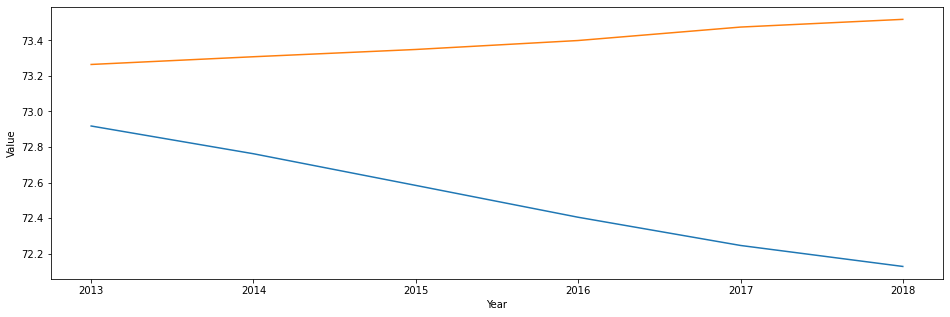

In [799]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [800]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 0.905100418144686
RMSE Error: 0.9513676566631252
Mean: 70.56840816326532


In [801]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [802]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [803]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,73.558789,Venezuela
2020,73.609098,Venezuela
2021,73.684843,Venezuela
2022,73.728240,Venezuela
2023,73.769117,Venezuela
2024,73.819425,Venezuela
2025,73.895171,Venezuela


In [804]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [805]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 72.50716666666666


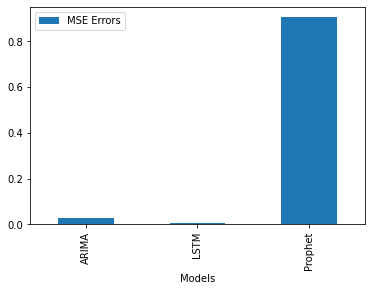

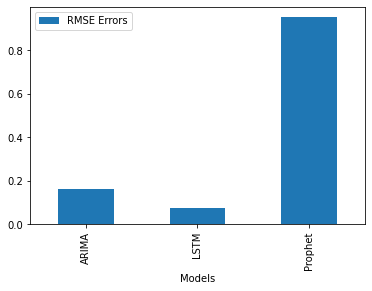

In [806]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [807]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.162426,0.026382,Venezuela
1,LSTM,0.076848,0.005906,Venezuela
2,Prophet,0.951368,0.905100,Venezuela


In [808]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [809]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,72.918,72.913225,72.834044,73.264189,Venezuela
2014,72.762,72.744175,72.650583,73.307585,Venezuela
2015,72.584,72.538649,72.486161,73.348462,Venezuela
2016,72.405,72.306843,72.339945,73.398771,Venezuela
2017,72.246,72.057233,72.210827,73.474516,Venezuela
2018,72.128,71.795393,72.097519,73.517913,Venezuela


In [810]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

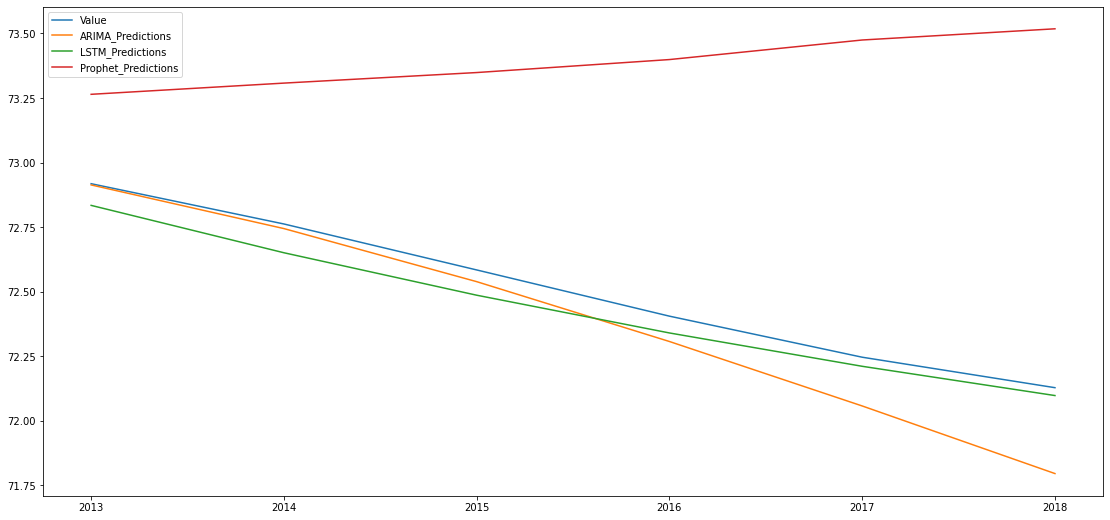

In [811]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))